In [1]:
import os
from bertopic import BERTopic
from bertopic.dimensionality import BaseDimensionalityReduction
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score

import pandas as pd
import numpy as np

import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.decomposition import PCA
from umap import UMAP
from umap import plot as umap_plot

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

In [ ]:

# Define directories
directory_in = "C:/Users/jmheijdrasuasnabar/Documents/LLMs4Bolts/Input"
directory_out = "C:/Users/jmheijdrasuasnabar/Documents/LLMs4Bolts/Output"

df_pre_analysis = pd.read_excel(directory_out + "/translated_and_assigned_df_100.xlsx")

# Get the column names and their indices as a dictionary
column_dict = {column_name: column_index for column_index, column_name in enumerate(df_pre_analysis.columns)}

# Display the updated column dictionary
column_dict
condition = (df_pre_analysis['assigned_to'] != 'RESERVE.CHILD') & (df_pre_analysis['assigned_to'] != 'RESERVE.OTHER') 
df_pre_analysis.text1 = df_pre_analysis.text1.str.replace("\\n", " ")
texts_list1 = df_pre_analysis.loc[condition, 'text1_translated'].tolist()
len(texts_list1)

85

In [ ]:
# this removes first 5 words of every entry because they give the sex and age of the patient (undesirable in topic modelling).
def remove_first_5_words_from_list(string_list):
    # Define a function to remove the first 5 words from a single string
    def remove_first_5_words(input_string):
        words = input_string.split()  # Split the string into a list of words
        return ' '.join(words[5:])  # Join the words starting from the 6th word
    
    # Apply the function to every string in the list
    return [remove_first_5_words(string) for string in string_list]

texts_list = remove_first_5_words_from_list(string_list = texts_list1)



In [4]:

def split_text_into_sentences(text):
    # Split the text into sentences using regex for sentence boundaries (ends with .!? followed by a space or end of string)
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return sentences

def chunk_sentences(sentences, chunk_size):
    # Split the list of sentences into chunks of size chunk_size
    for i in range(0, len(sentences), chunk_size):
        yield ' '.join(sentences[i:i + chunk_size])

def split_texts_list(texts_list, chunk_size):
    result = []
    for text in texts_list:
        sentences = split_text_into_sentences(text)
        result.extend(chunk_sentences(sentences, chunk_size))
    
    # Remove any empty strings from the result
    result = [chunk for chunk in result if chunk.strip()]
    return result

chunk_size = 10 #decided after testing various chuck sizes

split_texts = split_texts_list(texts_list, chunk_size=chunk_size)


In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords
#nltk.download('stopwords')

# Get the list of English stopwords
stop_words = stopwords.words('english')
stop_words.extend(['celiac', 'coeliac', 'disease', 'years', 'year', 'also', 'diagnosis', 'gluten-free'])
print(stop_words)

In [ ]:

model = SentenceTransformer(
    "dunzhang/stella_en_400M_v5",
    trust_remote_code=True,
    device="cpu",
    config_kwargs={"use_memory_efficient_attention": False, "unpad_inputs": False}
)

embeddings = model.encode(split_texts, normalize_embeddings=True)


In [ ]:

#dimensionality reduction (the below parameters resulted from a series of iterations and selecting best combination based on CV and silhouette score)
umap_model = UMAP(n_neighbors= 8, min_dist=0.0, n_components = 10, metric='cosine', random_state=42)

# clustering
hdbscan_model = SpectralClustering(random_state=42, n_clusters=17)

vectorizer_model = CountVectorizer(stop_words=stop_words)

spec_topic_model = BERTopic(umap_model=umap_model, 
                            hdbscan_model=hdbscan_model, 
                            vectorizer_model=vectorizer_model, 
                            calculate_probabilities=True, 
                            top_n_words = 15 #, # for better interpretability
                            )

spec_topics, probs = spec_topic_model.fit_transform(split_texts, embeddings=embeddings)

n_topics_found = len(spec_topic_model.get_topics())
spec_topic_model.get_topic_info()


In [ ]:
# Extract UMAP reduced embeddings from the BERTopic model
reduced_embeddings = spec_topic_model.umap_model.embedding_
topic_labels = spec_topics

# Calculate the silhouette score 
silhouette_avg = silhouette_score(reduced_embeddings, topic_labels, metric='cosine')
print(f'Silhouette score: {silhouette_avg}')



Silhouette score: 0.5218339562416077


In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Prepare the top words per topic for coherence calculation
topics = spec_topic_model.get_topics()  # Get the topics
top_words = [[word for word, _ in topics[i]] for i in range(len(topics)) if topics[i]]

# Convert split_texts into a list of lists (each document as a list of words)
texts_as_lists = [doc.split() for doc in split_texts]  

# Create a Gensim Dictionary
dictionary = Dictionary(texts_as_lists)

# Calculate different coherence scores
coherence_types = ['c_v']  # Add more types as needed , 'u_mass'
coherence_scores = {}

for coherence_type in coherence_types:
    coherence_model = CoherenceModel(topics=top_words, texts=texts_as_lists, dictionary=dictionary, coherence=coherence_type)
    coherence_scores[coherence_type] = coherence_model.get_coherence()



# Print the coherence scores
for c_type, score in coherence_scores.items():
    print(f'Topic Coherence ({c_type}): {score}')


Topic Coherence (c_v): 0.3654783840793883


In [ ]:
import json

#for (short) prompt later
topics_descriptions = spec_topic_model.get_topic_info()
topics_descriptions_json = topics_descriptions.drop(columns=['Count', 'Name']).to_json(orient='records')
print(topics_descriptions_json)

eg_json = {
                                            "topics": {
                                                "topic_0": {
                                                "label": "",
                                                "justification": "",
                                                "representative_words": ""
                                                },
                                                "topic_1": {
                                                "label": "",
                                                "justification": "",
                                                "representative_words": ""
                                                }
                                            }
}
print(eg_json)

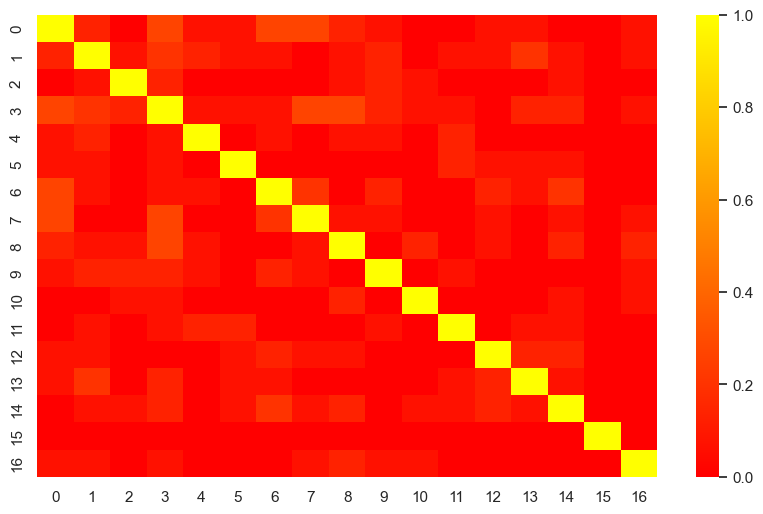

In [12]:
overlap = pd.DataFrame(index=np.arange(0, n_topics_found), columns=np.arange(0, n_topics_found)).fillna(0)

for topic_i, keywords_i in spec_topic_model.get_topics().items():
    for topic_j, keywords_j in spec_topic_model.get_topics().items():
        kw_i, kw_j = np.array(keywords_i)[:, 0], np.array(keywords_j)[:, 0]
        overlap.loc[topic_i, topic_j] = np.intersect1d(kw_i, kw_j).shape[0] / kw_i.shape[0]


with sns.plotting_context('notebook'):
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(overlap, cmap='autumn')

In [ ]:
# Get the topic embeddings from BERTopic model
topic_embeddings = spec_topic_model.topic_embeddings_

# Calculate pairwise cosine similarities between topic embeddings
cos_sim_matrix = cosine_similarity(topic_embeddings)

# To measure diversity
diversity_matrix = 1 - cos_sim_matrix

# Calculate average cosine dissimilarity (diversity)
average_diversity = np.mean(diversity_matrix[np.triu_indices_from(diversity_matrix, k=1)])
print(f"Average Topic Diversity (Cosine Dissimilarity): {average_diversity}")

In [14]:

spec_topic_model.visualize_hierarchy(orientation='bottom')


In [15]:
%run log_code.ipynb

def interpret_topics():
    output = call_gpt4(
        model = "gpt-4o-jh",
        messages=[
            {"role": "system", "content": "You are an experienced health economist researching health-related quality of life. You provide all your outputs exclusively in JSON format."},
            {"role": "user", "content": f"""I have some topics that contain the following representative keywords and representative documents. 
             
                                            ```{topics_descriptions_json}```

                                            Your task are simple: 
                                            first, translate each representative word into english. Include the translation in your JSON output. 
                                            Second, create a short label that describes each topic based on the keywords and representative documents. The short label should describe a single quality of life dimension or topic (i.e., not more than one!). In your JSON output, include a justifiaction for the choice of label.  
                                            Your JSON output should therefore have the following format: 
                                            {eg_json}
                                            """}
        ], 
        temperature=0.0, 
        seed=82, 
        max_tokens=4096
        )
    return output.choices[0].message.content


LLM_out = interpret_topics()
clean_json_str = LLM_out.replace('```json', '').replace('```', '').strip()
with open(directory_out + '/Topic modelling/LLM_BerTopic_interpret_stella_n85_b4merge.txt', 'w') as file: file.write(clean_json_str)

In [16]:
#Merge topics based on semantic meaning (LLM assisted) + hierarchy 

topics_to_merge = [[4,6,14],
                   [0,7,11,13]]
spec_topic_model.merge_topics(split_texts, topics_to_merge)

#for (short) prompt later
topics_descriptions = spec_topic_model.get_topic_info()
topics_descriptions_json = topics_descriptions.drop(columns=['Count', 'Name']).to_json(orient='records')



In [17]:
#Inspect updated hierarchy 
spec_topic_model.visualize_hierarchy(orientation='bottom')

In [18]:
#Get final topic labels

LLM_out = interpret_topics()
clean_json_str = LLM_out.replace('```json', '').replace('```', '').strip()
with open(directory_out + '/Topic modelling/LLM_BerTopic_interpret_stella_n85_final.txt', 'w') as file: file.write(clean_json_str)

In [19]:
topic_distr = spec_topic_model.approximate_distribution(texts_list)[0]
topic_distr # continue to use later


array([[0.10945517, 0.14871807, 0.        , ..., 0.        , 0.08030424,
        0.        ],
       [0.40466644, 0.27690699, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.45320523, 0.1517555 , 0.        , ..., 0.15033089, 0.        ,
        0.00933381],
       ...,
       [0.11748978, 0.14648972, 0.01988358, ..., 0.06065013, 0.        ,
        0.02932277],
       [0.12652151, 0.08809305, 0.07177341, ..., 0.05163662, 0.01558886,
        0.01093467],
       [0.28246413, 0.        , 0.        , ..., 0.28401856, 0.        ,
        0.        ]])

In [ ]:
#get Final C_v, silhouette, and diversity

# Get the topic embeddings from BERTopic model
topic_embeddings = spec_topic_model.topic_embeddings_

# Calculate pairwise cosine similarities between topic embeddings
cos_sim_matrix = cosine_similarity(topic_embeddings)

# To measure diversity
diversity_matrix = 1 - cos_sim_matrix

# Calculate average cosine dissimilarity (diversity)
average_diversity = np.mean(diversity_matrix[np.triu_indices_from(diversity_matrix, k=1)])
print(f"Average Topic Diversity (Cosine Dissimilarity): {average_diversity}")

# Prepare the top words per topic for coherence calculation
topics = spec_topic_model.get_topics()  # Get the topics
top_words = [[word for word, _ in topics[i]] for i in range(len(topics)) if topics[i]]

# Convert split_texts into a list of lists (each document as a list of words)
texts_as_lists = [doc.split() for doc in split_texts]  

# Create a Gensim Dictionary
dictionary = Dictionary(texts_as_lists)

# Calculate different coherence scores
coherence_types = ['c_v']  # Add more types as needed , 'u_mass'
coherence_scores = {}

for coherence_type in coherence_types:
    coherence_model = CoherenceModel(topics=top_words, texts=texts_as_lists, dictionary=dictionary, coherence=coherence_type)
    coherence_scores[coherence_type] = coherence_model.get_coherence()



# Print the coherence scores
for c_type, score in coherence_scores.items():
    print(f'Topic Coherence ({c_type}): {score}')


# Extract UMAP reduced embeddings from the BERTopic model
reduced_embeddings = spec_topic_model.umap_model.embedding_
topic_labels = spec_topics

# Calculate the silhouette score 
silhouette_avg = silhouette_score(reduced_embeddings, topic_labels, metric='cosine')
print(f'Silhouette score: {silhouette_avg}')



In [21]:

LLM_out_json = json.loads(clean_json_str)


# Prepare the data for DataFrame
rows = []
for topic_key, topic_value in LLM_out_json['topics'].items():
    row = {
        'Topic': topic_key,
        'Label': topic_value['label'],
        'Justification': topic_value['justification'],
        'Representative Words': topic_value['representative_words']
    }
    rows.append(row)

# Create the DataFrame
LLM_out_df = pd.DataFrame(rows)


colnames = LLM_out_df['Label'].tolist()
topic_distr_df = pd.DataFrame(topic_distr, columns= colnames)
# topic_distr_df = pd.DataFrame(topic_distr, columns= colnames[1:len(colnames)]) # if topics include topic -1, use this, otherwise, use above

topic_distr_df.to_excel(directory_out + "/Topic modelling/BerTopic_distributions_stella_n85_EN.xlsx", index = False)



In [ ]:

#The below code was used in preparatory stage to arrive at the final hyperparameters shown above (Bertopic chucks)

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import json


# Define the range of components and clusters to loop over
n_components_range = range(2, 20)
n_clusters_range = [5, 10, 15, 20]
n_neighbors_range = range(2,15)
# Function to calculate coherence scores
def calculate_coherence(topics, texts, dictionary):
    #coherence_types = ['c_v', 'u_mass']
    coherence_types = ['c_v']
    coherence_scores = {}
    for coherence_type in coherence_types:
        coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence=coherence_type)
        coherence_scores[coherence_type] = coherence_model.get_coherence()
    return coherence_scores

# Initialize a list to store results
results = []

# Prepare texts and dictionary for coherence score calculation
texts_as_lists = [doc.split() for doc in split_texts]  # Tokenized documents
dictionary = Dictionary(texts_as_lists)

# Loop over UMAP n_components and SpectralClustering n_clusters

for n_components in n_components_range:
    for n_neighbors in n_neighbors_range:
        for n_clusters in n_clusters_range:
            # Dimensionality reduction with UMAP
            umap_model = UMAP(min_dist= 0.0, n_neighbors=n_neighbors, n_components=n_components, metric='cosine', random_state=42)
            
            # Clustering with SpectralClustering
            hdbscan_model = SpectralClustering(random_state=42, n_clusters=n_clusters)
            
            vectorizer_model = CountVectorizer(stop_words=stop_words)

            # Fit BERTopic model
            spec_topic_model = BERTopic(umap_model=umap_model, 
                                        hdbscan_model=hdbscan_model, 
                                        vectorizer_model=vectorizer_model, 
                                        calculate_probabilities=True, 
                                        top_n_words=15)
            
            spec_topics, probs = spec_topic_model.fit_transform(split_texts, embeddings=embeddings)
            
            # Get reduced embeddings and topic labels
            reduced_embeddings = spec_topic_model.umap_model.embedding_
            topic_labels = spec_topics
            
            # Calculate silhouette and Davies-Bouldin scores
            silhouette_avg = silhouette_score(reduced_embeddings, topic_labels, metric='cosine')
            #db_score = davies_bouldin_score(reduced_embeddings, topic_labels)
            
            # Prepare topics for coherence calculation
            topics = spec_topic_model.get_topics()
            top_words = [[word for word, _ in topics[i]] for i in range(len(topics)) if topics[i]]
            
            # Calculate coherence scores
            coherence_scores = calculate_coherence(top_words, texts_as_lists, dictionary)
            
            # Get the topic embeddings from BERTopic model
            topic_embeddings = spec_topic_model.topic_embeddings_
            # Calculate pairwise cosine similarities between topic embeddings
            cos_sim_matrix = cosine_similarity(topic_embeddings)
            # To measure diversity
            diversity_matrix = 1 - cos_sim_matrix
            # Calculate average cosine dissimilarity (diversity)
            average_diversity = np.mean(diversity_matrix[np.triu_indices_from(diversity_matrix, k=1)])

            # Get topic descriptions and convert to JSON
            topics_descriptions = spec_topic_model.get_topic_info()
            topics_descriptions_json = topics_descriptions.drop(columns=['Count', 'Name']).to_json(orient='records')
        
            
            # Save the results in a dictionary
            results.append({
                'chunk_size': chunk_size,
                'n_neigh': n_neighbors,
                'n_components': n_components,
                'n_clusters': n_clusters,
                'silhouette_score': silhouette_avg,
                'c_v_score': coherence_scores['c_v'],
                'diversity': average_diversity,
                'topics_descriptions_json': topics_descriptions_json #,
            })

# Create a DataFrame from the results list
df_results = pd.DataFrame(results)

# Save the DataFrame to an Excel file
df_results.to_excel(directory_out + "/Topic modelling/TM_comparisons_stella_n85_EN_" + str(chunk_size) + "mindist0.xlsx", index=False)

